# LDM on Coarse Grid

Benchmarking different LDM methods vs non-LDM (with analytical Voigt of Whiting) on a coarse spectral grid.

Trying to understand LDM/non-LDM differences in the [Exojax implementation](https://github.com/HajimeKawahara/exojax/blob/develop/examples/tutorial/Cross%20Section%20using%20Discrete%20Integral%20Transform.ipynb).

In [1]:
# First, how to compute cross-sections with RADIS. In 0.9.29 that's not natively possible  


from radis import calc_spectrum, get_residual


def add_xsection(s):
    """ add cross section in a RADIS Spectrum"""
    from radis.phys.constants import k_b
    w, k = s.get('abscoeff')    # absorption coefficient in cm-1
    N = s.conditions['pressure_mbar']/k_b/s.conditions['Tgas']*1e-4 # cm-3
    sigma = k/N
    s._q["xsection"] = sigma
    s.units["xsection"] = "cm2"


Now let's compute a reference spectrum, with a very resolved grid :

Using cache file: C:\Users\erwan\.astropy\cache\astroquery\Hitran\tempfile_CO_1_1895.00_2305.00.h5
Using cache file: C:\Users\erwan\.astropy\cache\astroquery\Hitran\tempfile_CO_2_1895.00_2305.00.h5
HAPI version: 1.1.2.0
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005
Calculating Equilibrium Spectrum
Physical Conditions
----------------------------------------
   Tgas                 1000 K
   Trot              

d:\github\radis\radis\misc\warning.py:319: HighTemperatureWarning: HITRAN is valid for low temperatures (typically < 700 K). For higher temperatures you may need HITEMP or CDSD. See the 'databank=' parameter
  warnings.warn(WarningType(message))


Spectrum calculated in 2.44s


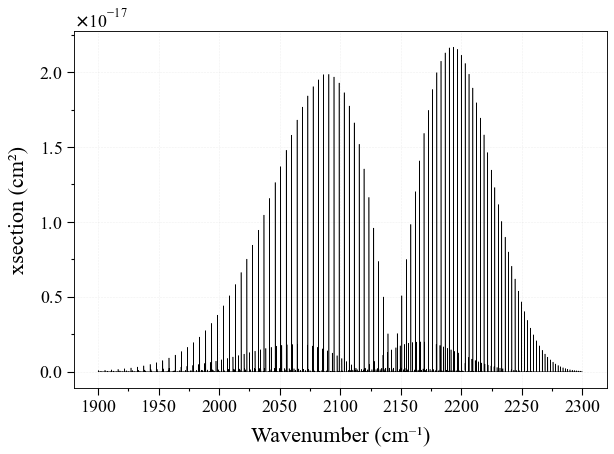

In [2]:

sref = calc_spectrum(1900, 2300, # cm-1
                  Tgas=1000,     # K
                  pressure=1e-3,     # bar
                  mole_fraction=1,  # 100% CO atmosphere
                  molecule='CO',
                  isotope='1,2',
                  wstep=(2300-1900)/80000/10,
                  optimization=None,  # default is LDM; set None to have analytical Voigt approximation
                  databank='hitran',
                  name='Reference')
add_xsection(sref)
sref.plot("xsection")


Now let's run on a coarser grid (0.005 cm-1) with a non-LDM implemnetation, LDM with simple weights, and LDM with optimized weights ("min-RMS")

(notice that RADIS will output AccuracyWarnings!)

In [3]:
%matplotlib ipympl
sref.plot("xsection", lw=4)
lw = 3
for optim in [None, "simple", "min-RMS"]:
    s = calc_spectrum(1900, 2300, # cm-1
                  Tgas=1000,     # K
                  pressure=1e-3,     # bar
                  mole_fraction=1,  # 100% CO atmosphere
                  molecule='CO',
                  isotope='1,2',
                  wstep=(2300-1900)/80000,
                  optimization=optim,  # default is LDM; set None to have analytical Voigt approximation
                  databank='hitran',
                  verbose=False,
                  name=optim if optim is not None else "Voigt")

    add_xsection(s)

    error = get_residual(s, sref, "xsection", ignore_nan=True)
    s.name += " (err {:.2e})".format(error)
    print(f"Error {optim} vs Ref : ", "{:.2e}".format(error))

    s.plot("xsection", nfig='same', lw=lw)
    lw -= 1

import matplotlib.pyplot as plt
plt.legend()
plt.xlim(2050.8,2050.9)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

d:\github\radis\radis\misc\warning.py:319: HighTemperatureWarning: HITRAN is valid for low temperatures (typically < 700 K). For higher temperatures you may need HITEMP or CDSD. See the 'databank=' parameter
  warnings.warn(WarningType(message))
d:\github\radis\radis\misc\warning.py:319: AccuracyWarning: Some lines are too narrow (FWHM ~ 0.008 cm⁻¹) for the current spectral grid (wstep=0.005). Please reduce wstep to below 0.0027 cm⁻¹. You can use wstep='auto' to get the optimal spectral grid value. You can also ignore by setting `warnings={'AccuracyWarning':'ignore'}` (if you know what you're doing!)
  warnings.warn(WarningType(message))


Error None vs Ref :  1.96e-22


d:\github\radis\radis\misc\warning.py:319: HighTemperatureWarning: HITRAN is valid for low temperatures (typically < 700 K). For higher temperatures you may need HITEMP or CDSD. See the 'databank=' parameter
  warnings.warn(WarningType(message))
d:\github\radis\radis\misc\warning.py:319: AccuracyWarning: Some lines are too narrow (FWHM ~ 0.008 cm⁻¹) for the current spectral grid (wstep=0.005). Please reduce wstep to below 0.0027 cm⁻¹. You can use wstep='auto' to get the optimal spectral grid value. You can also ignore by setting `warnings={'AccuracyWarning':'ignore'}` (if you know what you're doing!)
  warnings.warn(WarningType(message))


Error simple vs Ref :  1.95e-22


d:\github\radis\radis\misc\warning.py:319: HighTemperatureWarning: HITRAN is valid for low temperatures (typically < 700 K). For higher temperatures you may need HITEMP or CDSD. See the 'databank=' parameter
  warnings.warn(WarningType(message))
d:\github\radis\radis\misc\warning.py:319: AccuracyWarning: Some lines are too narrow (FWHM ~ 0.008 cm⁻¹) for the current spectral grid (wstep=0.005). Please reduce wstep to below 0.0027 cm⁻¹. You can use wstep='auto' to get the optimal spectral grid value. You can also ignore by setting `warnings={'AccuracyWarning':'ignore'}` (if you know what you're doing!)
  warnings.warn(WarningType(message))


Error min-RMS vs Ref :  7.46e-23


(2050.8, 2050.9)